## Archivo de Pruebas

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [10]:
DATA_PATH = os.path.join("..", "data", "diabetes_prediction_dataset.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separar la variable objetivo y las características
target = "diabetes"
X = df.drop(columns=[target])
y = df[target]

# Identificar variables categóricas y numéricas
categorical_features = ["gender", "smoking_history"]
numeric_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level", "hypertension", "heart_disease"]

# Preprocesamiento para variables categóricas (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Preprocesamiento para variables numéricas (escalado estándar)
numeric_transformer = StandardScaler()

# Crear preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Separar en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar preprocesamiento a los datos de entrenamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Verificar dimensiones después del preprocesamiento
X_train_preprocessed.shape, X_test_preprocessed.shape

((80000, 15), (20000, 15))

#### Comparación de modelos

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir modelos iniciales:
# 1) Regresión Logística
# 2) Random Forest
# 3) XGBoost
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Entrenar y evaluar modelos
results = {}

for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    
    # Evaluar métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# Convertir resultados a un DataFrame y mostrar
results_df = pd.DataFrame(results).T
results_df

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Definir el modelo XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    random_state=42
)

# Definir los hiperparámetros a probar
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 5, 10, 20],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=10, cv=3, scoring="recall", 
    n_jobs=-1, random_state=42, verbose=1
)

# Entrenar el modelo
random_search.fit(X_train_preprocessed, y_train)

# Obtener los mejores parámetros y el mejor score (recall)
best_params = random_search.best_params_
best_recall = random_search.best_score_

best_params, best_recall


Fitting 3 folds for each of 10 candidates, totalling 30 fits


({'subsample': 1.0,
  'n_estimators': 200,
  'max_depth': 20,
  'learning_rate': 0.3,
  'colsample_bytree': 0.8},
 np.float64(0.7099983219849945))

#### Recall obtenido: 0.7099 (no es óptimo)

#### Comprobamos que los datos están desbalanceados, se optimiza el parámetro *'scale_pos_weight'* con XGBClassifier

In [19]:
from collections import Counter
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]  # Ratio entre clases

xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    random_state=42, 
    scale_pos_weight=scale_pos_weight  # Ajuste de balanceo real
)

# Definir los hiperparámetros a probar
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 5, 10, 20],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=10, cv=3, scoring="recall", 
    n_jobs=-1, random_state=42, verbose=1
)

# Entrenar el modelo
random_search.fit(X_train_preprocessed, y_train)

# Obtener los mejores parámetros y el mejor score (recall)
best_params = random_search.best_params_
best_recall = random_search.best_score_

best_params, best_recall

Fitting 3 folds for each of 10 candidates, totalling 30 fits


({'subsample': 0.6,
  'n_estimators': 200,
  'max_depth': 5,
  'learning_rate': 0.01,
  'colsample_bytree': 1.0},
 np.float64(0.9420592968714819))

In [18]:
from sklearn.metrics import recall_score

# Obtener probabilidades en lugar de predicciones
y_pred_probs = random_search.best_estimator_.predict_proba(X_test_preprocessed)[:, 1]

# Probar con un umbral más bajo (Ej: 0.3 en lugar de 0.5)
threshold = 0.3
y_pred_adjusted = (y_pred_probs >= threshold).astype(int)

# Evaluar nuevo Recall
new_recall = recall_score(y_test, y_pred_adjusted)
print("Nuevo Recall ajustado:", new_recall)


Nuevo Recall ajustado: 0.731764705882353


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definir preprocesamiento
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, ["age", "bmi", "blood_glucose_level"]),
    ("cat", categorical_transformer, ["gender", "smoking_history"])
])

# Crear Pipeline con preprocesamiento + modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Aplicar validación cruzada correctamente
scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")

print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.94115 0.9399  0.93905 0.9395  0.93875]
Mean accuracy: 0.9396699999999999


In [25]:
from sklearn.model_selection import GridSearchCV

# Definir parámetros a optimizar en el Pipeline
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [5, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)


Mejores hiperparámetros: {'classifier__max_depth': 5, 'classifier__n_estimators': 50}


In [26]:
# Pasos a realizar en un Pipeline:
# 1. Imputación de valores faltantes
# 2. Escalado de datos
# 3. Codificación de variables categóricas
# 4. Entrenamiento del modelo

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definir preprocesamiento
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, ["age", "bmi", "blood_glucose_level"]),
    ("cat", categorical_transformer, ["gender", "smoking_history"])
])

# Crear Pipeline con preprocesamiento + modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Aplicar validación cruzada correctamente
scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")

print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation accuracy scores: [0.94115 0.9399  0.93905 0.9395  0.93875]
Mean accuracy: 0.9396699999999999


              precision    recall  f1-score      support
0              0.946274  1.000000  0.972396  18300.00000
1              1.000000  0.388824  0.559932   1700.00000
accuracy       0.948050  0.948050  0.948050      0.94805
macro avg      0.973137  0.694412  0.766164  20000.00000
weighted avg   0.950841  0.948050  0.937336  20000.00000


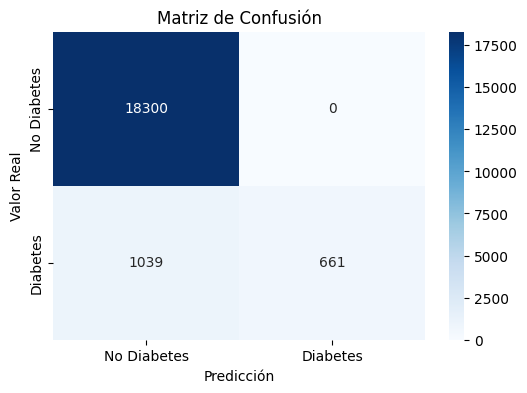

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener predicciones en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)

# Generar reporte de clasificación
report = classification_report(y_test, y_pred, output_dict=True)

# Convertir el reporte en un DataFrame para visualización
report_df = pd.DataFrame(report).transpose()

# Mostrar el reporte de clasificación
print(report_df)

# Generar matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()